In [52]:
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from pickle import dump
from IPython.display import display
import seaborn as sns
import tensorflow 
from tensorflow import keras
from keras import backend as K
tensorflow.random.set_seed(1)
%matplotlib inline

In [53]:
def create_dataframe(data_path):
    df = []
    for c in ['0','1','2','3','4','5','6','7','8','9']:
        class_folder = os.path.join(data_path, c)
        for f in os.listdir(class_folder):
            f_path = os.path.join(class_folder, f)
            if f_path.endswith('.jpg'):
                df.append([f_path, c])
    df = pd.DataFrame(df, columns=('filename', 'class'))
    
    return df

In [54]:
IMG_DIM=224
DATA_PATH = '/kaggle/input/handwritten-characters'
CLASSES = sorted(['0','1','2','3','4','5','6','7','8','9'])
NUM_CLASSES = len(CLASSES)
print(CLASSES)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [55]:
df = create_dataframe(os.path.join(DATA_PATH, 'Train'))
df_test = create_dataframe(os.path.join(DATA_PATH, 'Validation'))

In [56]:
pwd

'/kaggle/working'

In [57]:
from sklearn.model_selection import train_test_split

In [58]:
df_train, df_val = train_test_split(df, test_size=0.30, random_state=0)

In [59]:
print(sorted(df_val['class'].unique()))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [60]:
df_val

,filename,class
405331,/kaggle/input/handwritten-characters/Train/9/3...,9
108461,/kaggle/input/handwritten-characters/Train/1/4...,1
392510,/kaggle/input/handwritten-characters/Train/9/1...,9
312094,/kaggle/input/handwritten-characters/Train/7/7...,7
309709,/kaggle/input/handwritten-characters/Train/7/1...,7
...,...,...
203371,/kaggle/input/handwritten-characters/Train/4/2...,4
248756,/kaggle/input/handwritten-characters/Train/5/6...,5
357599,/kaggle/input/handwritten-characters/Train/8/2...,8
336040,/kaggle/input/handwritten-characters/Train/7/4...,7


In [61]:
df_train.shape

(291288, 2)

In [62]:
df_test.shape

(11453, 2)

In [63]:
df_val.shape

(124838, 2)

In [64]:
df_val.info

<bound method DataFrame.info of                                                  filename class
405331  /kaggle/input/handwritten-characters/Train/9/3...     9
108461  /kaggle/input/handwritten-characters/Train/1/4...     1
392510  /kaggle/input/handwritten-characters/Train/9/1...     9
312094  /kaggle/input/handwritten-characters/Train/7/7...     7
309709  /kaggle/input/handwritten-characters/Train/7/1...     7
...                                                   ...   ...
203371  /kaggle/input/handwritten-characters/Train/4/2...     4
248756  /kaggle/input/handwritten-characters/Train/5/6...     5
357599  /kaggle/input/handwritten-characters/Train/8/2...     8
336040  /kaggle/input/handwritten-characters/Train/7/4...     7
159608  /kaggle/input/handwritten-characters/Train/3/1...     3

[124838 rows x 2 columns]>

In [65]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [66]:
train_gen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=10,
    zoom_range = 0.1,  
    width_shift_range=0.1, 
    height_shift_range=0.1,     
    fill_mode='nearest'
        ).flow_from_dataframe(
    df_train,
    target_size=(IMG_DIM, IMG_DIM),
    classes=CLASSES,
    batch_size=32,
    class_mode='sparse'
)

val_gen = ImageDataGenerator(rescale=1/255).flow_from_dataframe(
    df_val,
    target_size=(IMG_DIM, IMG_DIM),
    classes=CLASSES,
    batch_size=32,
    class_mode='sparse'
)

test_gen = ImageDataGenerator(rescale=1/255).flow_from_dataframe(
    df_test,
    target_size=(IMG_DIM, IMG_DIM),
    classes=CLASSES,
    shuffle=False,
    batch_size=32,
    class_mode='sparse'
)

Found 291288 validated image filenames belonging to 10 classes.
Found 124838 validated image filenames belonging to 10 classes.
Found 11453 validated image filenames belonging to 10 classes.


In [67]:
train_gen.class_indices


{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [68]:
test_gen.class_indices


{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [69]:
val_gen.class_indices


{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [78]:
from keras.applications.vgg19 import VGG19
from keras.models import Model

def create_model_vgg19(optimizer='adam'):
    model = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_DIM, IMG_DIM, 3))
    
    for layer in model.layers:
        layer.trainable = False
        
    x = Flatten()(model.output)
    output = Dense(NUM_CLASSES, activation='sigmoid')(x)

    model = Model(inputs=model.inputs, outputs=output)
    model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
    return model

In [79]:
model_weights_file_path = "num.h5"

In [80]:
from tensorflow.keras.layers import Flatten

In [81]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense

In [82]:
model = create_model_vgg19(optimizer='adam')

In [83]:
model.input_shape

(None, 224, 224, 3)

In [84]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


checkpoint = ModelCheckpoint(filepath=model_weights_file_path, monitor="val_loss", verbose=1, save_best_only=True, mode="min", save_weights_only=True)
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=20)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='min', min_delta=0.0001, cooldown=0, min_lr=0)
num_epochs = 70  # Define the number of epochs

history = model.fit(train_gen,
                    epochs=num_epochs,      
                    steps_per_epoch=200,
                    validation_steps=150,
                    validation_data=val_gen,
                    callbacks=[checkpoint, es, lr_reduce], 
                    batch_size=32,
                    verbose=1)

Epoch 1/70
200/200 [==============================] - ETA: 0s - loss: 0.5259 - accuracy: 0.8508
Epoch 1: val_loss improved from inf to 0.14261, saving model to num.h5
200/200 [==============================] - 119s 589ms/step - loss: 0.5259 - accuracy: 0.8508 - val_loss: 0.1426 - val_accuracy: 0.9635 - lr: 0.0010
Epoch 2/70
200/200 [==============================] - ETA: 0s - loss: 0.1584 - accuracy: 0.9542
Epoch 2: val_loss improved from 0.14261 to 0.12634, saving model to num.h5
200/200 [==============================] - 134s 669ms/step - loss: 0.1584 - accuracy: 0.9542 - val_loss: 0.1263 - val_accuracy: 0.9652 - lr: 0.0010
Epoch 3/70
200/200 [==============================] - ETA: 0s - loss: 0.1503 - accuracy: 0.9573
Epoch 3: val_loss did not improve from 0.12634
200/200 [==============================] - 117s 583ms/step - loss: 0.1503 - accuracy: 0.9573 - val_loss: 0.1559 - val_accuracy: 0.9517 - lr: 0.0010
Epoch 4/70
200/200 [==============================] - ETA: 0s - loss: 0.135

In [86]:
def plot_loss_accuracy(history):
    plt.figure(figsize=[8,6])
    plt.plot(history.history['loss'],'r',linewidth=3.0)
    plt.plot(history.history['val_loss'],'b',linewidth=3.0)
    plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Loss Curves',fontsize=16)

    plt.figure(figsize=[8,6])
    plt.plot(history.history['accuracy'],'g',linewidth=3.0)
    plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.title('Accuracy Curves',fontsize=16)

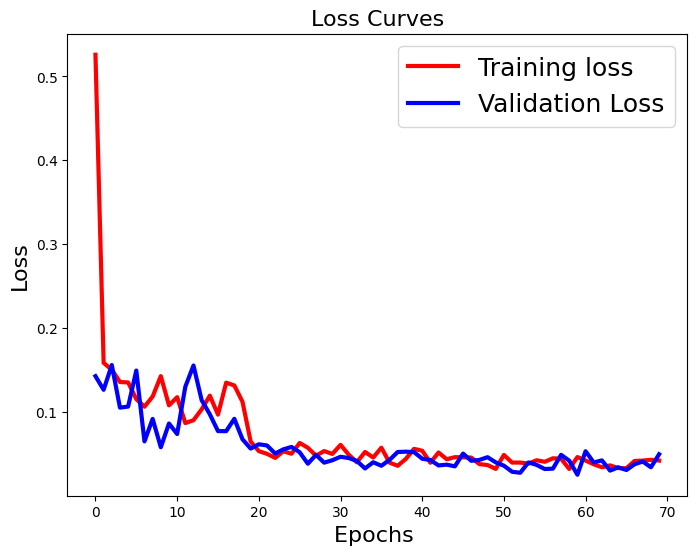

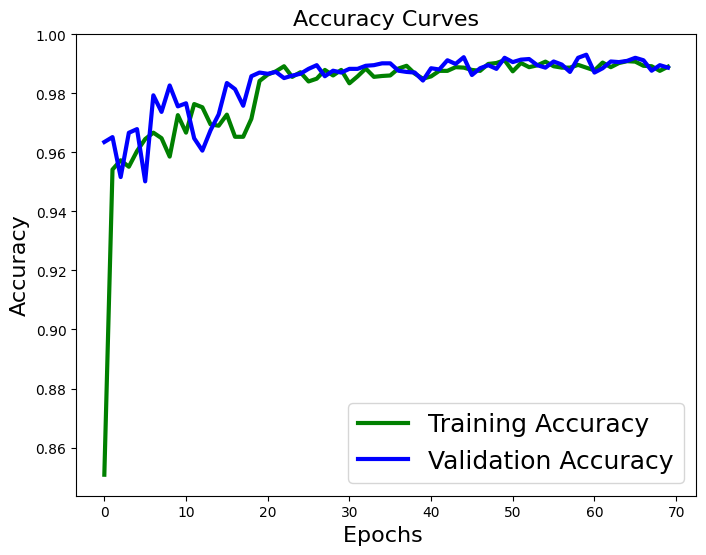

In [87]:
plot_loss_accuracy(history)


In [88]:
saved_model = create_model_vgg19(optimizer='adam')
saved_model.load_weights(model_weights_file_path)

In [89]:
saved_model.evaluate(val_gen)

3902/3902 [==============================] - 636s 163ms/step - loss: 0.0395 - accuracy: 0.9892


[0.0394723117351532, 0.9892100095748901]

In [90]:
saved_model.evaluate(test_gen)

358/358 [==============================] - 76s 213ms/step - loss: 0.0267 - accuracy: 0.9913


[0.026692302897572517, 0.9912686347961426]

In [ ]:
model.save("numbers.h5")